In [2]:
%cd /Users/peterwu/Dropbox/Nichols_Data_mining/
import numpy as np
import pandas as pd
phenotype=pd.read_csv('Data/Nich_Price_quantitative.csv',header=None,index_col=0)
#Note: the first 324 conditions are from Nichols, the last 162 are from Price

/Users/peterwu/Dropbox/Nichols_Data_mining


In [3]:
phenotype=phenotype.reset_index() #now the ids are on the 1st column (type: int64)
name=['ids']
name.extend(list(range(1,486+1)))
name
phenotype.columns=name

In [4]:
import pyreadr
result = pyreadr.read_r('Data/sourced/id_allAttributes.RData')
id_allAttributes=result['id_allAttributes']
id_allAttributes=id_allAttributes.astype({'ids': 'int64'})

In [5]:
df=phenotype.merge(id_allAttributes,on="ids",how='left')

In [27]:
annot='pcomplex'
id_annot=df[['ids',annot]].drop_duplicates()
id_annot.columns=['ids','annot']
id_annot_table=pd.DataFrame(id_annot.iloc[:,1].value_counts())

In [64]:
#Note: These ptcomplexes were manually selected (had to select mutually exclusive)
index=["CPLX0-7452","NADH-DHI-CPLX","CPLX0-3382","CPLX0-250","FHLMULTI-CPLX","ABC-8-CPLX"]#member at least>=6
id_selected=id_annot.query('annot in @index').sort_values(by=['annot'])
print(id_selected.annot.value_counts())
print(id_selected)

CPLX0-7452       26
CPLX0-3382       12
NADH-DHI-CPLX    12
CPLX0-250         9
FHLMULTI-CPLX     7
ABC-8-CPLX        6
Name: annot, dtype: int64
         ids          annot
137139  3351     ABC-8-CPLX
137073  1784     ABC-8-CPLX
137046  1938     ABC-8-CPLX
137025  2575     ABC-8-CPLX
136998  2483     ABC-8-CPLX
...      ...            ...
106050   457  NADH-DHI-CPLX
103458   381  NADH-DHI-CPLX
102798   305  NADH-DHI-CPLX
101430    88  NADH-DHI-CPLX
184059    17  NADH-DHI-CPLX

[72 rows x 2 columns]


In [65]:
#Do these pathways have mutually exclusive ids? =>yes
sum(id_selected.ids.value_counts()!=1)

0

In [66]:
id_selected_phenotype=id_selected.merge(phenotype,on="ids",how='left')
X=id_selected_phenotype.iloc[:,2:]
#normalize the features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = pd.DataFrame(min_max_scaler.fit_transform(X))
X_Nich_only=X.iloc[:,0:324]
y=np.array(id_selected.annot)

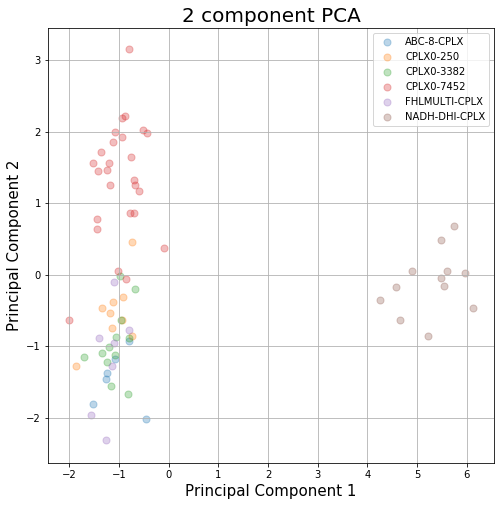

In [97]:
#PCA
##ref: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

finalDf = pd.concat([principalDf, pd.DataFrame(y)], axis = 1)
finalDf.columns = ['principal component 1', 'principal component 2','target']


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

NUM_COLORS = len(np.unique(np.array(y)))
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


targets = np.unique(y) 

for target in targets:
  indicesToKeep = (finalDf['target'] == target)
  ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'], finalDf.loc[indicesToKeep, 'principal component 2'], s = 50, alpha=0.3)
ax.legend(targets)
ax.grid()

plt.show()

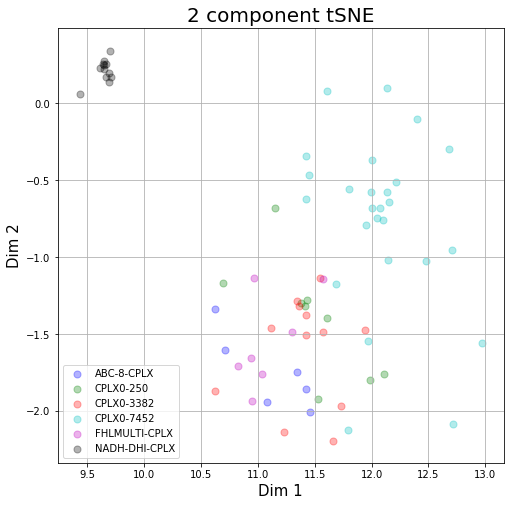

In [98]:
# t-SNE
##ref: https://medium.com/@sourajit16.02.93/tsne-t-distributed-stochastic-neighborhood-embedding-state-of-the-art-c2b4b875b7da
from sklearn.manifold import TSNE 


# Module for standardization
from sklearn.preprocessing import StandardScaler
#Get the standardized data
standardized_data = StandardScaler().fit_transform(X)

model = TSNE(n_components=2,perplexity=50,n_iter=100000) #n_components means the lower dimension

low_dim_data = pd.DataFrame(model.fit_transform(standardized_data))


finalDf = pd.concat([low_dim_data, pd.DataFrame(y)], axis = 1)
finalDf.columns = ['Dim 1', 'Dim 2','target']


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Dim 1', fontsize = 15)
ax.set_ylabel('Dim 2', fontsize = 15)
ax.set_title('2 component tSNE', fontsize = 20)
targets = np.unique(y)

from itertools import cycle
cycol = cycle('bgrcmk')

for target in targets:
  indicesToKeep = (finalDf['target'] == target)
  ax.scatter(finalDf.loc[indicesToKeep, 'Dim 1'], finalDf.loc[indicesToKeep, 'Dim 2'], s = 50, color=next(cycol), alpha=0.3)
ax.legend(targets)
ax.grid()

In [90]:
#source the self-defined ML functions
%run machine_learning/ml_inner_cross_val.py

cv=3
test_size=0.2
random_state=10

In [91]:
ds = [1,2,3,4]
Cs = [0.001, 0.01, 0.1, 1, 10,100,1000] #ref: https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
kernels=['linear', 'poly', 'rbf', 'sigmoid'] # I removed 'precomputed' kernel because it only accepts data that looke like: (n_samples, n_samples). Ref: https://stackoverflow.com/questions/36306555/scikit-learn-grid-search-with-svm-regression/36309526
param_grid={'degree':ds,'C':Cs, 'kernel':kernels}

my_svm(X,y,cv,param_grid)
my_svm(X.iloc[:,0:324],y,cv,param_grid)

/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best hyper-parameters: {'C': 100, 'degree': 1, 'kernel': 'rbf'}
Average accuracy, precision=  0.8 0.7944444444444444
Best hyper-parameters: {'C': 1, 'degree': 1, 'kernel': 'linear'}
Average accuracy, precision=  0.7333333333333333 0.7


/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/peterwu/opt/anaconda3/envs/R_and_python/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
